In [28]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import cv2 as cv
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
tfds.disable_progress_bar()
train_ds, validation_ds, test_ds = tfds.load("cats_vs_dogs",
         split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
         as_supervised=True)

In [3]:
img_size = (150, 150)
img_shape = (*img_size, 3)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))

In [4]:
batch_size = 32

#Using caching and prefetching to opt load speed
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [5]:
data_augmentation = keras.Sequential(
    [keras.layers.RandomFlip("horizontal"), keras.layers.RandomRotation(0.1),]
)

In [6]:
base_model = keras.applications.Xception(
    weights="imagenet",
    input_shape=img_shape,
    include_top=False)

base_model.trainable = False

In [7]:
#model top
inputs = keras.Input(shape=img_shape)
x = data_augmentation(inputs)

scale_layer = keras.layers.Rescaling(scale=1/127.5, offset=-1)

x = scale_layer(x)

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
out = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, out)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [10]:
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.BinaryCrossentropy(),
             metrics=[keras.metrics.BinaryAccuracy()])

In [11]:
epochs = 10

model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/10
291/291 [==============================] - 159s 541ms/step - loss: 0.1325 - binary_accuracy: 0.9457 - val_loss: 0.0771 - val_binary_accuracy: 0.9699
Epoch 2/10
291/291 [==============================] - 169s 580ms/step - loss: 0.1184 - binary_accuracy: 0.9524 - val_loss: 0.0784 - val_binary_accuracy: 0.9678
Epoch 3/10
291/291 [==============================] - 173s 594ms/step - loss: 0.1068 - binary_accuracy: 0.9570 - val_loss: 0.0730 - val_binary_accuracy: 0.9712
Epoch 4/10
291/291 [==============================] - 170s 584ms/step - loss: 0.1029 - binary_accuracy: 0.9582 - val_loss: 0.0732 - val_binary_accuracy: 0.9686
Epoch 5/10
291/291 [==============================] - 168s 576ms/step - loss: 0.1043 - binary_accuracy: 0.9579 - val_loss: 0.0783 - val_binary_accuracy: 0.9686
Epoch 6/10
291/291 [==============================] - 167s 575ms/step - loss: 0.0994 - binary_accuracy: 0.9610 - val_loss: 0.0738 - val_binary_accuracy: 0.9712
Epoch 7/10
291/291 [====================

In [13]:
hist = model.history

pred = model.predict(test_ds)

73/73 [==============================] - 32s 433ms/step


In [20]:
def pred_class(prediction):
    for i in range(len(prediction)):
        
        if prediction[i][0] >= 0.5:
            prediction[i] = 1
        else:
            prediction[i] = 0
    return prediction

In [21]:
def destruct_tfds(dataset):
    final_ds = []
    img_ds = []
    #take all batches in data from ds
    for img, label in test_ds.take(tf.data.experimental.cardinality(dataset)):
        #from each batch, unssemble it and add to final_ds
        for i in range(*label.shape):
            final_ds.append(int(label[i]))
            img_ds.append(img[i])
    return final_ds, img_ds

final_test_ds, img_test_ds = destruct_tfds(test_ds)

In [1]:
def find_error(pred, truth):
    error_data = []
    #just checking hehe
    #assert(len(pred) == len(truth))
    #iter over pred-truth
    for i in range(len(pred)):
        if pred[i] - truth[i] != 0:
            error_data.append(i)
    return error_data

errors = find_error(pred, final_test_ds)

NameError: name 'pred' is not defined

In [23]:
def filter_errors_img(images, error_list):
    error_img_ds = []
    for i in range(len(error_list)):
        error_img_ds.append(images[error_list[i]])
    return error_img_ds

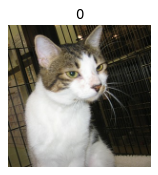

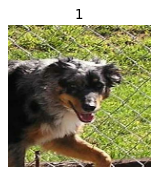

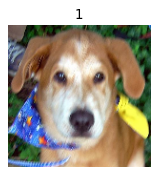

In [43]:
def display_img(img_list, errors):
    for i in range(len(img_list)):
        plt.figure(figsize=(8, 8), dpi=80)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(img_list[i],np.int32))
        plt.title(int(pred[errors[i]]))
        plt.axis('off')
        if i == 2:
            break
display_img(img_test_ds, errors)

In [26]:
pred = pred_class(pred)

In [44]:
print(confusion_matrix(final_test_ds, pred))
print(accuracy_score(final_test_ds, pred))

[[1140   37]
 [  24 1125]]
0.9737747205503009


In [45]:
img_list = filter_errors_img(img_test_ds, errors)

In [46]:
len(img_list)

2326

In [32]:
model.save('xcep_trans_learn.h5')

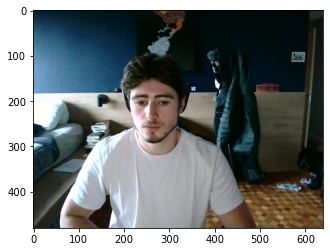

In [47]:
img = plt.imread("opencv frame 0.png")
img1 = plt.imread("opencv frame 1.png")
img2 = plt.imread("opencv frame 2.png")
plt.imshow(img)

In [48]:
def adj_img(image):
    width = int(224)
    dim = (width, width)
    img_resize = cv.resize(image, dim)
    adjusted_image = np.expand_dims(img_resize, axis=0)
    return adjusted_image

In [49]:
img_resize_1 = adj_img(img)
img_resize_2 = adj_img(img1)
img_resize_3 = adj_img(img2)

In [50]:
pred_1 = model.predict(img_resize_1)
pred_2 = model.predict(img_resize_2)
pred_3 = model.predict(img_resize_3)

print(pred_1, pred_2, pred_3)

1/1 [==============================] - 0s 50ms/step
[[0.5236403]] [[0.52437395]] [[0.52453655]]
